In [97]:
import torch
import matplotlib.pyplot as plt
from torch import nn

In [98]:
# the numerical equation
# y = 0.05 + sum_over_d(0.01 * x(d)) + epsilon

n_train, n_test, num_inputs, batch_size = 20,100,200,5
true_w = torch.ones((num_inputs,1)) * 0.01
true_bias = 0.05
X =  torch.normal(0,1,(n_train+n_test,num_inputs))
y = torch.matmul(X , true_w) + true_bias
y += torch.normal(0,0.01,(y.shape)) #noise

In [99]:
y.shape, X.shape

(torch.Size([120, 1]), torch.Size([120, 200]))

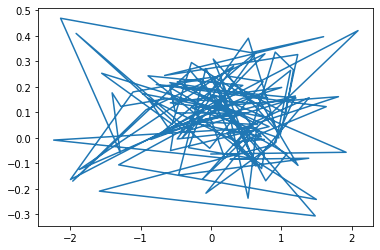

In [100]:
plt.plot(X[:,1], y)

In [101]:
# now that we have the features we needto train the dataset and create data iter

train_dataset = torch.utils.data.TensorDataset(*(X[:n_train], y[:n_train]))
test_dataset =torch.utils.data.TensorDataset(*(X[n_train+1:], y[n_train+1:]))

In [102]:
train_iter = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=batch_size)

In [103]:
test_iter = torch.utils.data.DataLoader(test_dataset, shuffle=True, batch_size=batch_size)

## Implementation from scratch

In [104]:
def init_params():
    w = torch.normal(0,1,size=(num_inputs,1), requires_grad=True)
    b = torch.zeros(1, requires_grad=True)
    return w,b

In [105]:
def l2_penalty(w):
    return torch.sum(w.pow(2))/2

In [106]:
def linreg(X, w, b):
    return torch.matmul(X,w) + b

In [107]:
def squared_loss(y_hat, y):
    return 0.5 * (y_hat - y) ** 2
    

In [116]:
def sgd(params, lr, batch_size):
    with torch.no_grad():
        for param in params:
            param -= param.grad * lr / batch_size
            param.grad.zero_()
    
    

In [108]:
def evaluate_loss(net, data_iter, loss,w,b, ttext):
    current_loss = 0
    current_number = 0
#     print(ttext)
    with torch.no_grad():
        for X, y in data_iter:
            y_hat = net(X,w,b)
#             print(y_hat.shape, y.shape)
            l = loss(y_hat, y)
#             print(l)
            current_loss += l.sum()
            current_number += len(y)
    return current_loss/current_number
        
        

In [119]:
def train(lambd):
    w,b = init_params()
    net = linreg
    loss = squared_loss
    
    num_epochs = 100
    learning_rate = 0.003
    
    optimizer = sgd
    
    train_loss_array = []
    test_loss_array = []
    for epoch in range(num_epochs):
        for X, y in train_iter:
            l = loss(net(X,w,b), y) - lambd * l2_penalty(w)
        
            l.sum().backward()
            optimizer([w,b],0.01, batch_size)
    
            

        train_loss_array.append(evaluate_loss(net, train_iter,loss,w,b,"train"))
        test_loss_array.append(evaluate_loss(net, test_iter, loss,w,b, "test"))

    print("l2 norm of w: ", torch.norm(w).item())
    
    plt.plot(range(0, num_epochs), train_loss_array)
    plt.plot(range(0, num_epochs), test_loss_array)
    plt.show()
            
        
            
    
    

l2 norm of w:  2062736.625


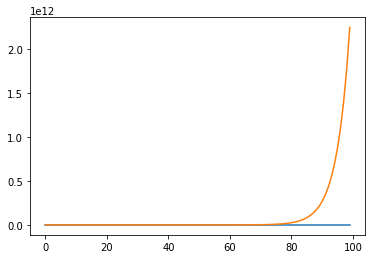

In [120]:
train(lambd=3)

l2 norm of w:  12.217097282409668


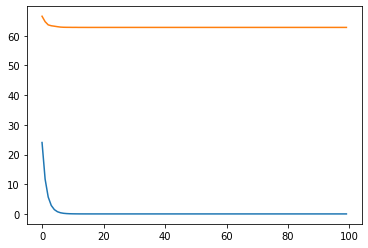

In [121]:
train(lambd=0)

# making a concise implementation

In [112]:
def evaluate_loss_concise(net, data_iter, loss):
    
    total_loss = 0
    total_number = 0
    with torch.no_grad():
        for X, y in data_iter:
            l = loss(net(X), y)
            
            total_loss += l.sum()
            total_number += l.numel()
    
    return total_loss/total_number

In [113]:


def train_concise(wd):
    net = nn.Sequential(nn.Linear(num_inputs, 1))
    for param in net.parameters():
        param.data.normal_()
    
    loss = nn.MSELoss()
    num_epochs=100
    lr =0.003
    
    optimizer = torch.optim.SGD([{
        "params": net[0].weight,
        "weight_decay":wd
    }, {
        "params": net[0].bias
    }], lr= lr)
    
    train_array = []
    test_array = []
    for epoch in range(num_epochs):
        for X,y in train_iter:
            y_hat = net(X)
            l = loss(y_hat, y)
        
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
        train_array.append(evaluate_loss_concise(net, train_iter, loss))
        test_array.append(evaluate_loss_concise(net, test_iter, loss))
    
    plt.plot(range(num_epochs), train_array)
    plt.plot(range(num_epochs), test_array)
    plt.grid(True)
    plt.show()
                           

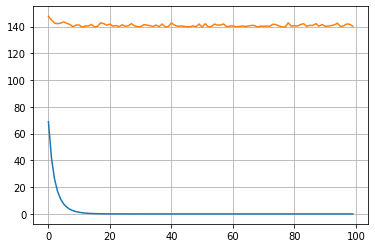

In [114]:
train_concise(0)

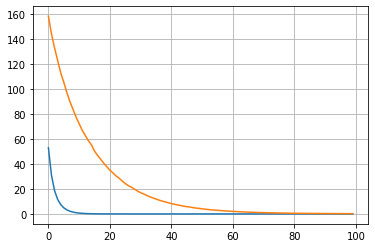

In [115]:
train_concise(3)

### Exercises

1. Experiment with the value of λ in the estimation problem in this section. Plot training and
test accuracy as a function of λ. What do you observe?
2. Use a validation set to find the optimal value of λ. Is it really the optimal value? Does this
matter?
3. What would the update equations look like if instead of ∥w∥
2 we used ∑
i
|wi
| as our penalty
of choice (L1 regularization)?
4. We know that ∥w∥
2 = w⊤w. Can you find a similar equation for matrices (see the Frobenius
norm in Section 2.3.10)?
5. Review the relationship between training error and generalization error. In addition to
weight decay, increased training, and the use of a model of suitable complexity, what other
ways can you think of to deal with overfitting?
6. In Bayesian statistics we use the product of prior and likelihood to arrive at a posterior via
P(w | x) ∝ P(x | w)P(w). How can you identify P(w) with regularization?

In [130]:
# 1

def train_concise_no_graph(wd):
    net = nn.Sequential(nn.Linear(num_inputs,1))
    for param in net.parameters():
        param.data.normal_()
    
    lr = 0.03
    
    loss = nn.MSELoss()
    optimizer = torch.optim.SGD([{
        "params": net[0].weight,
        "weight_decay": wd,
    }, {
        "params": net[0].bias,
    }], lr=lr)
    
    for epoch in range(20):
        for X, y in train_iter:
            l = loss(net(X), y)
            
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
            
    return evaluate_loss_concise(net, train_iter, loss), evaluate_loss_concise(net, test_iter, loss)
    
    

for -5 , train loss: 3.85178078764073e+16, test loss: 3908750146535424.0
for -4 , train loss: 2485851640561664.0, test loss: 181346672574464.0
for -3 , train loss: 482131084050432.0, test loss: 36149854732288.0
for -2 , train loss: 9797090934784.0, test loss: 701725671424.0
for -1 , train loss: 133611274240.0, test loss: 11363183616.0
for 0 , train loss: 171352457216.0, test loss: 15930233856.0
for 1 , train loss: 196724672.0, test loss: 21396716.0
for 2 , train loss: 339042336.0, test loss: 37392464.0
for 3 , train loss: 1312558.0, test loss: 124304.125
for 4 , train loss: 350001.0, test loss: 37496.4921875
for 5 , train loss: 6994.46630859375, test loss: 757.1814575195312
for 6 , train loss: 162.39968872070312, test loss: 20.543676376342773
for 7 , train loss: 14.520292282104492, test loss: 1.2998311519622803
for 8 , train loss: 1.092522382736206, test loss: 0.1718440055847168
for 9 , train loss: 0.037111107259988785, test loss: 0.051036953926086426
for 10 , train loss: 0.07688823342

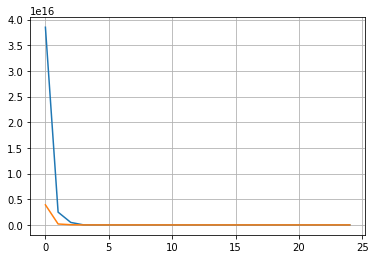

In [131]:
train_loss_array = []
test_loss_array = []

for i in range(-5, 20):
    train_l, test_l = train_concise_no_graph(i)
    print(f"for {i} , train loss: {train_l}, test loss: {test_l}")
    train_loss_array.append(train_l)
    test_loss_array.append(test_l)

plt.plot(range(25), train_loss_array)
plt.plot(range(25), test_loss_array)
plt.grid(True)
plt.show()
    



In [133]:
#2

num_valid = 100
X_valid = torch.normal(0,0.1, (num_valid,num_inputs))
y_valid = torch.matmul(X_valid, true_w) + true_bias

valid_dataset = torch.utils.data.TensorDataset(*(X_valid, y_valid))
valid_dataloader = torch.utils.data.DataLoader(valid_dataset,shuffle=True, batch_size=32)


In [137]:
def validation_dataset_trainer(wd):
    net = nn.Sequential(nn.Linear(num_inputs, 1))
    
    for param in net.parameters():
        param.data.normal_()
    
    optimizer = torch.optim.SGD([{
        "params": net[0].weight,
        "weight_decay": wd
    }, {
        "params": net[0].bias,
    }], lr=0.03)
    
    loss = nn.MSELoss()
    
    for epoch in range(20):
        for X, y in valid_dataloader:
            l = loss(net(X), y)
            
            optimizer.zero_grad()
            l.backward()
            optimizer.step()
    
    return evaluate_loss_concise(net, valid_dataloader, loss)

21


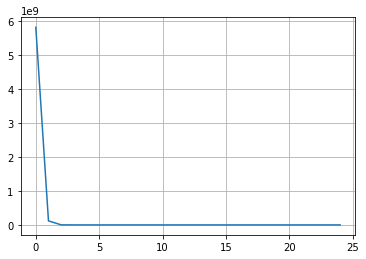

In [142]:
valid_loss_array = []
for wd in range(-5, 20):
    valid_loss_array.append(validation_dataset_trainer(wd))

print(valid_loss_array.index(min(valid_loss_array)))
    
plt.plot(range(25), valid_loss_array)
plt.grid(True)
plt.show()


In [155]:
#3

#https://stackoverflow.com/questions/42704283/adding-l1-l2-regularization-in-pytorch
def l1_norm_with_abs(w):
    return torch.abs(w).sum()


tensor(-13.8499)
tensor(-0.9671)


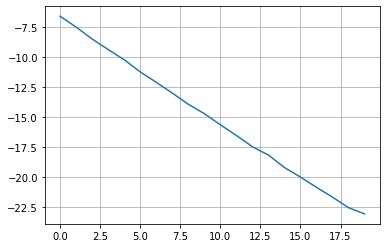

In [156]:
# training for l1 norm
model = nn.Sequential(nn.Linear(num_inputs, 1))

for param in model.parameters():
    param.data.normal_()
    print(l1_norm(param.detach()))
    
loss = nn.MSELoss()

optimizer = torch.optim.SGD(model.parameters(), lr = 0.03)

valid_loss_array = []
for epoch in range(20):
    current_loss = 0
    current_number = 0
    for X, y in valid_dataloader:
        l = loss(model(X),y) - l1_norm_with_abs(model[0].weight)
        
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
        
        current_loss += l.detach()
        current_number += len(y)
    
    valid_loss_array.append(current_loss/current_number)

plt.plot(range(20), valid_loss_array)
plt.grid(True)
plt.show()

#4 

dont know lets check forbenius norm.
f(αx) = |α|f(x).  I dont understand.

#5

larger size, dropout

#6

It wants us to predict bayes rule just like thta I dont know how its possible